In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import matplotlib.image as mp

%config InlineBackend.figure_format = 'retina'

In [75]:
def factorize(A, k, device=torch.device("cpu"), epsilon = 0.001):
	"""Factorize the matrix D into A and B"""
	A = A.to(device)
	# Randomly initialize A and B
	W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
	H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
	# Optimizer
	optimizer = optim.Adam([W, H], lr=0.01)
	mask = ~torch.isnan(A)
	epoch = 0
	# Train the model
	for i in range(2500):
		# Compute the loss
		optimizer.zero_grad()
		diff_matrix = torch.mm(W, H) - A
		diff_vector = diff_matrix[mask]
		loss = torch.norm(diff_vector,'fro')**2

		# Zero the gradients

		# Backpropagate
		loss.backward()

		# Update the parameters
		optimizer.step()
		# epoch += 1
		# if epoch>1:
		# 	if prev_loss-loss < epsilon:
		# 		break
		# prev_loss = loss
		# if epoch>=100 and epoch%100==0:
		#     print(f'Epoch:{epoch}--->Loss:{loss}, prev_loss:{prev_loss}')

	# print(f'No of Epochs:{epoch}')

	return W, H, loss

def reconstruct_img(masked_image,factors=50,device=torch.device("cpu")):#returns torch
	W, H, _ = factorize(masked_image,factors,device)
	reconstruct_img = torch.mm(W, H).cpu().detach()
	return reconstruct_img


def factorize_3d(A, k, device=torch.device("cpu"), epsilon = 0.001):
	A = A.to(device)
	if A.shape[2] == 3:
		# A1,A2,A3 = A[:,:,0],A[:,:,1],A[:,:,2]
		A_3d = A.permute(2,0,1)
	else:
		A_3d = A
	W_3d = []
	H_3d = []
	loss_3d = []

	for a in A_3d:
		W,H,loss = factorize(a,k,device,epsilon)
		W_3d.append(W)
		H_3d.append(H)
		loss_3d.append(loss)

	return W_3d,H_3d,loss_3d

# def factorize_3d(A, k, device=torch.device("cpu"), epsilon = 0.001):
# 	A = A.to(device)
# 	if A.shape[2] == 3:
# 		R,G,B = A[:,:,0],A[:,:,1],A[:,:,2]
# 		h,w = A.shape[:2]
# 		# A_3d = A.permute(2,0,1)
# 	else:
# 		R,G,B = A[0],A[1],A[2]
# 		h,w = A.shape[1:]
# 	B = torch.cat([R, G, B], dim=1)

# 	W, H, loss = factorize(B,k,device)
# 	reconstructed = torch.mm(W, H)

# 	R = reconstructed[:, :w]            # First section: Red channel
# 	G = reconstructed[:, w:2*w]     # Second section: Green channel
# 	B = reconstructed[:, 2*w:3*w]   # Third section: Blue channel

# 	return torch.stack([R,G,B])



(300, 300, 3)


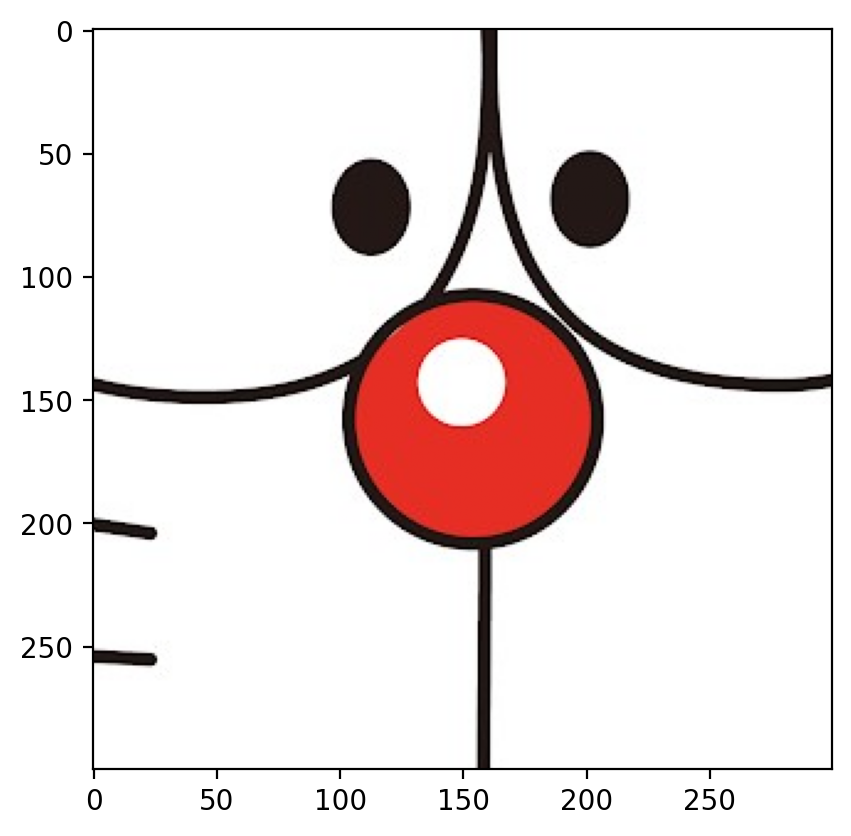

In [103]:
img = mp.imread('abcd.jpg')
img = img.copy()
img = img[200:500, 400:700, :]/255
print(img.shape)
plt.imshow(img)
img = torch.from_numpy(img)

In [104]:
# torch.manual_seed(42)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(42)
#     torch.cuda.manual_seed_all(42)
# def mask_image(img, prop):
#     img = img.clone()
#     img = img.to(torch.float32)
#     mask = torch.rand(img.shape) < prop
#     img[mask] = float('nan')
#     return img, mask

def mask_image(img, prop):
    """
    Mask a 3D image by randomly setting a proportion of values to NaN.
    
    Parameters:
    - img (torch.Tensor): A 3D image tensor of shape (channels, height, width).
    - prop (float): The proportion of values to mask (between 0 and 1).
    
    Returns:
    - img_copy (torch.Tensor): The masked image with some values set to NaN.
    - mask (torch.Tensor): The mask used to set the values to NaN.
    """
    img_copy = img.clone()
    # img_copy = img_copy.permute(2,0,1)
    img_copy = img_copy.to(torch.float32)

    # Generate a 2D mask of shape (height, width)
    mask_2d = torch.rand(img.shape[0], img.shape[1]) < prop

    # Expand mask to match the image's 3D shape (channels, height, width)
    mask = mask_2d.unsqueeze(2).expand_as(img)

    # Set masked values to NaN
    img_copy[mask] = float('nan')
    # img_copy = img_copy.permute(1,2,0)
    
    return img_copy, mask


c:\Users\abhir\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


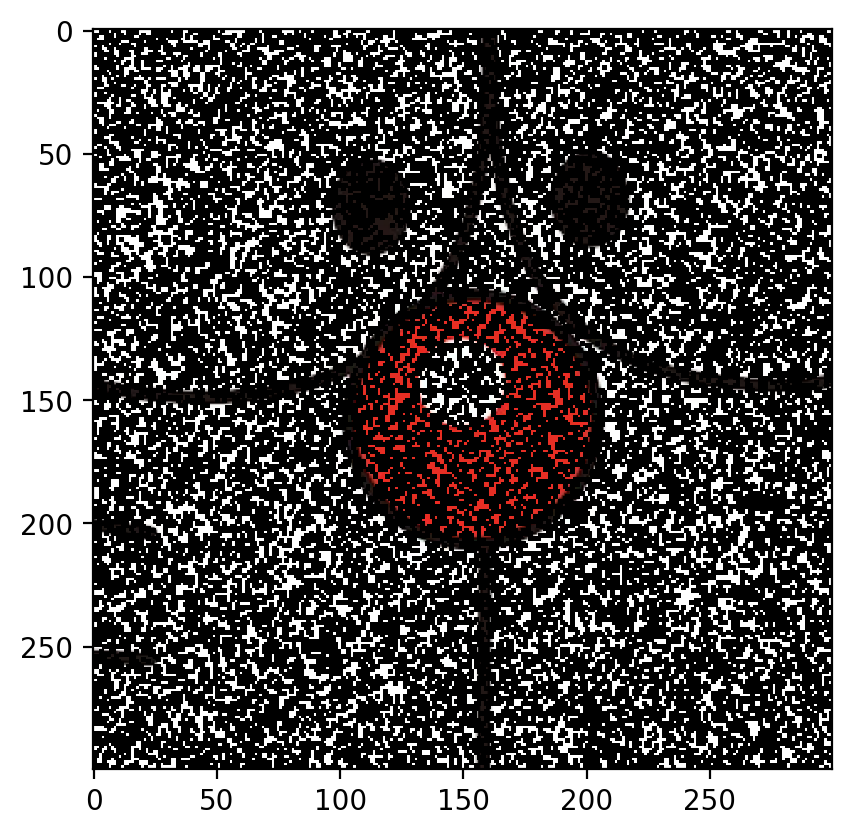

In [106]:
masked_img, mask = mask_image(img, prop=0.3)
plt.imshow(masked_img)

In [107]:
def reconstruct_3d_img(masked_image,factors=50,device=torch.device("cpu")):
	W_3d,H_3d,_ = factorize_3d(masked_image,factors,device)
	A = []
	for i in range(3):
		a = torch.mm(W_3d[i], H_3d[i]).cpu().detach()
		A.append(a)
	A = torch.stack(A)
	return A

In [115]:
# W_3d,H_3d,_ = factorize_3d(img,30,device=torch.device("cpu"))

# A = []
# for i in range(3):
# 	a = torch.mm(W_3d[i], H_3d[i]).cpu().detach()
# 	A.append(a)

re_img = reconstruct_3d_img(masked_img,100)


In [116]:
re_img1 = re_img.permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


c:\Users\abhir\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


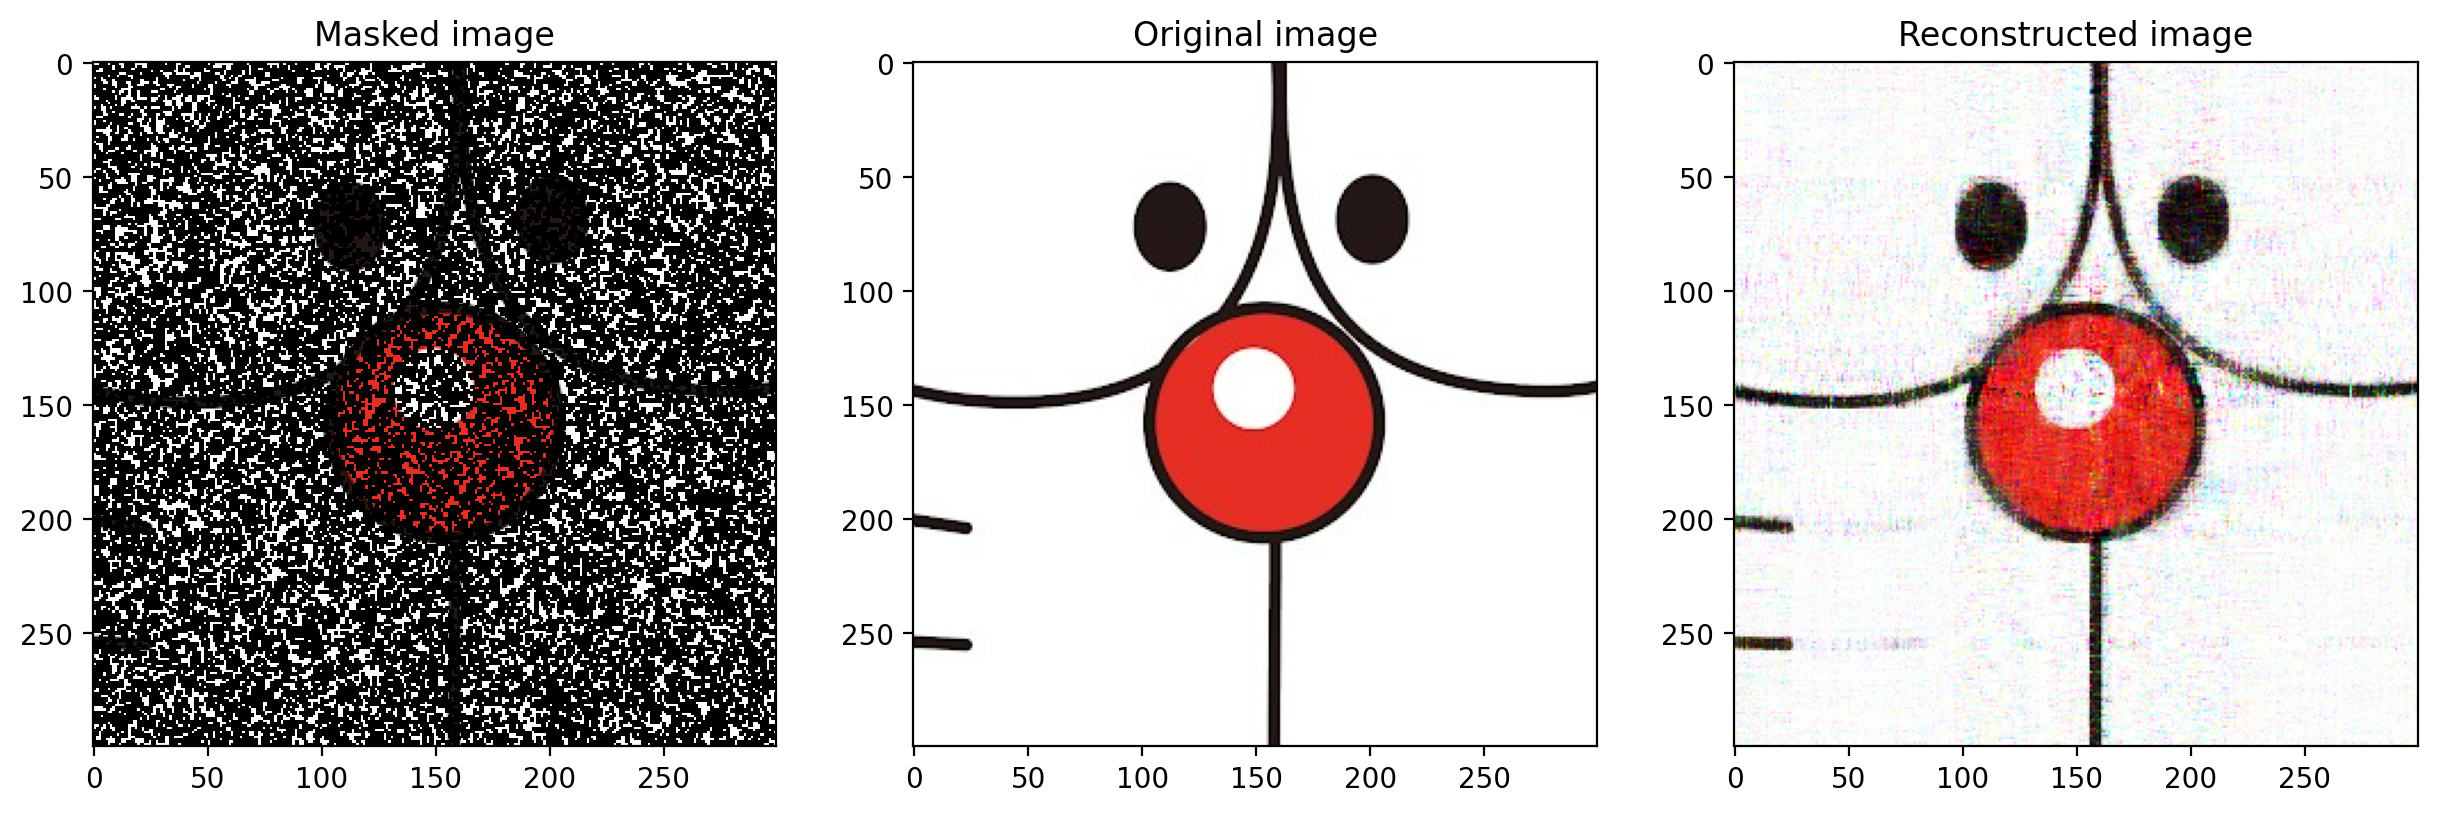

In [117]:
re_img1 = re_img1.cpu().detach().numpy()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(masked_img, cmap='gray')
ax[0].set_title("Masked image")
ax[1].imshow(img, cmap="gray")
ax[1].set_title("Original image")
ax[2].imshow(re_img1, cmap='gray')
ax[2].set_title("Reconstructed image")
# fig.suptitle(f'prop:{prop}, factors:{factors}')
plt.show()